## Urbanization Vs PM 2.5 (eg, 2016)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Step 1: Data Loading
# Load Urban.csv using default comma delimiter.
urban = pd.read_csv("Urban.csv", encoding="utf-8")

# Load Air quality.csv with automatic delimiter detection using the Python engine.
air_quality = pd.read_csv("Air quality.csv", sep=None, engine="python", encoding="utf-8", on_bad_lines="skip")


In [2]:
# Choose the analysis year (e.g., 2016).
selected_year = 2016

In [3]:
# See the first five rows of data
urban.head()

,Country Name,Indicator Name,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,Urban population (% of total population),42.990000,43.041000,43.108000,43.192000,43.293000,43.411000,43.546000,43.697000,43.866000,44.052000
1,Africa Eastern and Southern,Urban population (% of total population),33.496557,33.959633,34.447281,34.919544,35.396289,35.893398,36.384272,36.884034,37.393633,37.909012
2,Afghanistan,Urban population (% of total population),24.373000,24.587000,24.803000,25.020000,25.250000,25.495000,25.754000,26.026000,26.314000,26.616000
3,Africa Western and Central,Urban population (% of total population),43.587953,44.218278,44.849099,45.473850,46.094137,46.709753,47.322617,47.931021,48.531971,49.129808
4,Angola,Urban population (% of total population),62.002000,62.731000,63.446000,64.149000,64.839000,65.514000,66.177000,66.825000,67.460000,68.081000


In [4]:
air_quality.head()

,WHO Region,ISO3,WHO Country Name,City or Locality,Measurement Year,PM2.5 (μg/m3),PM10 (μg/m3),NO2 (μg/m3),PM25 temporal coverage (%),PM10 temporal coverage (%),NO2 temporal coverage (%),Reference,Number and type of monitoring stations,Version of the database,Status,Unnamed: 15,Unnamed: 16
0,Eastern Mediterranean Region,AFG,Afghanistan,Kabul,2019,119.77,NaN,NaN,18.0,NaN,NaN,"U.S. Department of State, United States Enviro...",NaN,2022,NaN,NaN,NaN
1,European Region,ALB,Albania,Durres,2015,NaN,17.65,26.63,NaN,NaN,83.961187,European Environment Agency (downloaded in 2021),NaN,2022,NaN,NaN,NaN
2,European Region,ALB,Albania,Durres,2016,14.32,24.56,24.78,NaN,NaN,87.932605,European Environment Agency (downloaded in 2021),NaN,2022,NaN,NaN,NaN
3,European Region,ALB,Albania,Elbasan,2015,NaN,NaN,23.96,NaN,NaN,97.853881,European Environment Agency (downloaded in 2021),NaN,2022,NaN,NaN,NaN
4,European Region,ALB,Albania,Elbasan,2016,NaN,NaN,26.26,NaN,NaN,96.049636,European Environment Agency (downloaded in 2021),NaN,2022,NaN,NaN,NaN


In [5]:
print(urban.columns)

Index(['Country Name', 'Indicator Name', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022'],
      dtype='object')


In [6]:
print(air_quality.columns)

Index(['WHO Region', 'ISO3', 'WHO Country Name', 'City or Locality',
       'Measurement Year', 'PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)',
       'PM25 temporal coverage (%)', 'PM10 temporal coverage (%)',
       'NO2 temporal coverage (%)', 'Reference',
       'Number and type of monitoring stations', 'Version of the database',
       'Status', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')


In [7]:
# Step 2: Data Preprocessing 
# Verify and convert "Measurement Year" to numeric.
if "Measurement Year" not in air_quality.columns:
    raise KeyError("The 'Measurement Year' column is missing in the air quality data.")
air_quality["Measurement Year"] = pd.to_numeric(air_quality["Measurement Year"], errors="coerce")

# Filter air quality data for the selected year.
aq_year = air_quality[air_quality["Measurement Year"] == selected_year]

# Convert the selected year to a string for column lookup in the urban dataset.
year_str = str(selected_year)

# Extract the relevant year column from urban data and rename it to "Urbanization".
if year_str not in urban.columns:
    raise KeyError(f"The '{year_str}' column is missing in the Urban data.")
urban_subset = urban[["Country Name", year_str]].rename(columns={year_str: "Urbanization"})

# Clean country names by stripping whitespace and converting to lower case.
aq_year["WHO Country Name"] = aq_year["WHO Country Name"].str.strip().str.lower()
urban_subset["Country Name"] = urban_subset["Country Name"].str.strip().str.lower()

/tmp/ipykernel_14406/1014550570.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aq_year["WHO Country Name"] = aq_year["WHO Country Name"].str.strip().str.lower()


In [8]:
# Step 3: Data Merging 
# Merge the two datasets on the country name.
merged_df = pd.merge(
    urban_subset,
    aq_year[["WHO Country Name", "PM2.5 (μg/m3)"]],
    left_on="Country Name",
    right_on="WHO Country Name",
    how="inner"
).drop(columns=["WHO Country Name"])

# Preliminary check of the merged data.
print("\n--- Before Data Cleaning ---")
print(merged_df.info())
print(merged_df.head())



--- Before Data Cleaning ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3789 entries, 0 to 3788
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country Name   3789 non-null   object 
 1   Urbanization   3789 non-null   float64
 2   PM2.5 (μg/m3)  1914 non-null   float64
dtypes: float64(2), object(1)
memory usage: 88.9+ KB
None
  Country Name  Urbanization  PM2.5 (μg/m3)
0      albania        58.421          14.32
1      albania        58.421            NaN
2      albania        58.421          28.64
3      albania        58.421            NaN
4      andorra        88.248            NaN


In [9]:
# Step 4: Data Cleaning 
# Convert "Urbanization" and "PM2.5 (μg/m3)" to numeric (non-numeric values become NaN).
merged_df["Urbanization"] = pd.to_numeric(merged_df["Urbanization"], errors="coerce")
merged_df["PM2.5 (μg/m3)"] = pd.to_numeric(merged_df["PM2.5 (μg/m3)"], errors="coerce")

# Remove rows with missing (NaN) values in either column.
merged_df = merged_df.dropna(subset=["Urbanization", "PM2.5 (μg/m3)"])

# Remove rows with infinite values.
merged_df = merged_df[~merged_df.isin([np.inf, -np.inf]).any(axis=1)]

# Filter out unrealistic values:
# - Urbanization should be within 0 to 100 (as percentages).
# - PM2.5 values should be non-negative.
merged_df = merged_df[(merged_df["Urbanization"] >= 0) & (merged_df["Urbanization"] <= 100)]
merged_df = merged_df[merged_df["PM2.5 (μg/m3)"] >= 0]

# Check the cleaned data.
print("\n--- After Data Cleaning ---")
print(merged_df.info())
print(merged_df.describe())


--- After Data Cleaning ---
<class 'pandas.core.frame.DataFrame'>
Index: 1914 entries, 0 to 3787
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country Name   1914 non-null   object 
 1   Urbanization   1914 non-null   float64
 2   PM2.5 (μg/m3)  1914 non-null   float64
dtypes: float64(2), object(1)
memory usage: 59.8+ KB
None
       Urbanization  PM2.5 (μg/m3)
count   1914.000000    1914.000000
mean      69.054403      23.863454
std       14.409745      19.208396
min       18.942000       0.010000
25%       56.736000      10.212500
50%       69.855000      15.455000
75%       79.917000      34.377500
max      100.000000     156.320000


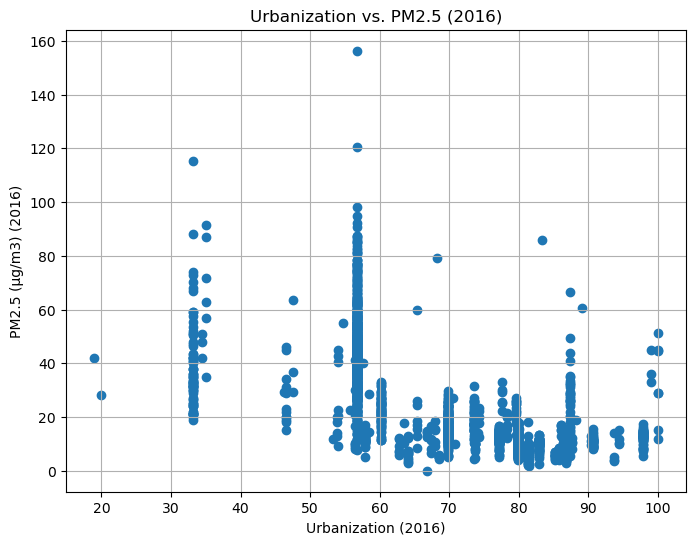

Correlation between Urbanization and PM2.5 (2016): -0.633

Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:          PM2.5 (μg/m3)   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     1281.
Date:                Sat, 22 Mar 2025   Prob (F-statistic):          3.78e-215
Time:                        21:48:39   Log-Likelihood:                -7881.2
No. Observations:                1914   AIC:                         1.577e+04
Df Residuals:                    1912   BIC:                         1.578e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

In [10]:
#Step 5: Data Analysis
if merged_df.empty:
    print("The merged dataset is empty after cleaning. Please review the cleaning rules or input data.")
else:
    # Visualization: Scatter plot of Urbanization vs. PM2.5.
    plt.figure(figsize=(8,6))
    plt.scatter(merged_df["Urbanization"], merged_df["PM2.5 (μg/m3)"])
    plt.xlabel(f"Urbanization ({selected_year})")
    plt.ylabel(f"PM2.5 (μg/m3) ({selected_year})")
    plt.title(f"Urbanization vs. PM2.5 ({selected_year})")
    plt.grid(True)
    plt.show()

    # Calculate and print the Pearson correlation coefficient.
    correlation = merged_df["Urbanization"].corr(merged_df["PM2.5 (μg/m3)"])
    print(f"Correlation between Urbanization and PM2.5 ({selected_year}): {correlation:.3f}")

    # OLS Regression Analysis: Predict PM2.5 using Urbanization.
    X = sm.add_constant(merged_df["Urbanization"])
    y = merged_df["PM2.5 (μg/m3)"]
    model = sm.OLS(y, X).fit()

    # Print the regression model summary.
    print("\nRegression Model Summary:")
    print(model.summary())

## Urbanization Vs NO2 (eg, 2016)

In [11]:
# Step 3: Data Merging
# Ensure the NO2 column exists in the air quality data
if "NO2 (μg/m3)" not in aq_year.columns:
    raise KeyError("The 'NO2 (μg/m3)' column is missing in the air quality data.")

# Merge datasets on matching country names
merged_df = pd.merge(
    urban_subset,
    aq_year[["WHO Country Name", "NO2 (μg/m3)"]],
    left_on="Country Name",
    right_on="WHO Country Name",
    how="inner"
).drop(columns=["WHO Country Name"])

print("\n--- Before Data Cleaning ---")
print(merged_df.info())
print(merged_df.head())


--- Before Data Cleaning ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3789 entries, 0 to 3788
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  3789 non-null   object 
 1   Urbanization  3789 non-null   float64
 2   NO2 (μg/m3)   2769 non-null   float64
dtypes: float64(2), object(1)
memory usage: 88.9+ KB
None
  Country Name  Urbanization  NO2 (μg/m3)
0      albania        58.421        24.78
1      albania        58.421        26.26
2      albania        58.421        12.52
3      albania        58.421          NaN
4      andorra        88.248        26.98


In [12]:
# Step 4: Data Cleaning
# Convert "Urbanization" and "NO2 (μg/m3)" columns to numeric
merged_df["Urbanization"] = pd.to_numeric(merged_df["Urbanization"], errors="coerce")
merged_df["NO2 (μg/m3)"] = pd.to_numeric(merged_df["NO2 (μg/m3)"], errors="coerce")

# Drop rows with missing values in either column
merged_df = merged_df.dropna(subset=["Urbanization", "NO2 (μg/m3)"])

# Remove rows with infinite values
merged_df = merged_df[~merged_df.isin([np.inf, -np.inf]).any(axis=1)]

# Filter out unrealistic values:
# - Urbanization should be between 0 and 100
# - NO2 values should be non-negative
merged_df = merged_df[(merged_df["Urbanization"] >= 0) & (merged_df["Urbanization"] <= 100)]
merged_df = merged_df[merged_df["NO2 (μg/m3)"] >= 0]

print("\n--- After Data Cleaning ---")
print(merged_df.info())
print(merged_df.describe())



--- After Data Cleaning ---
<class 'pandas.core.frame.DataFrame'>
Index: 2769 entries, 0 to 3788
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  2769 non-null   object 
 1   Urbanization  2769 non-null   float64
 2   NO2 (μg/m3)   2769 non-null   float64
dtypes: float64(2), object(1)
memory usage: 86.5+ KB
None
       Urbanization  NO2 (μg/m3)
count   2769.000000  2769.000000
mean      70.825806    20.548696
std       15.138230    11.830991
min       30.082000     0.000000
25%       64.086000    11.940000
50%       77.224000    18.850000
75%       79.917000    27.000000
max      100.000000    89.770000


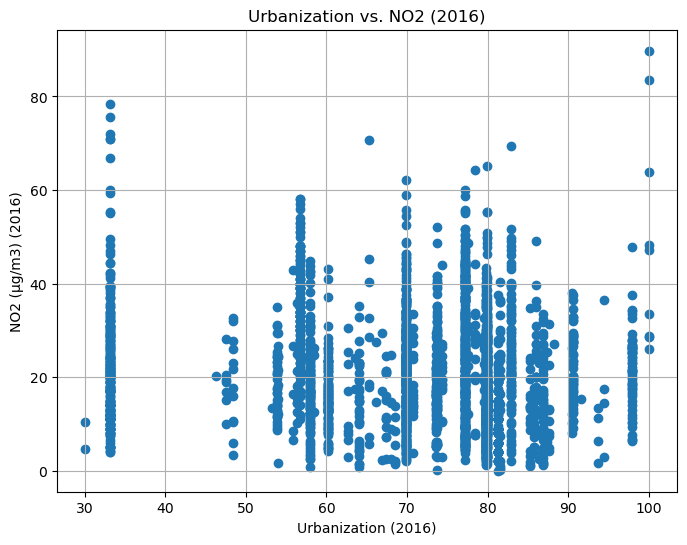

Correlation between Urbanization and NO2 (2016): -0.093

Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:            NO2 (μg/m3)   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     24.28
Date:                Sat, 22 Mar 2025   Prob (F-statistic):           8.81e-07
Time:                        21:48:39   Log-Likelihood:                -10758.
No. Observations:                2769   AIC:                         2.152e+04
Df Residuals:                    2767   BIC:                         2.153e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [13]:
# Step 5: Data Analysis
if merged_df.empty:
    print("The cleaned merged dataset is empty. Please review the cleaning rules or input data.")
else:
    # Visualization: Scatter plot of Urbanization vs. NO2
    plt.figure(figsize=(8,6))
    plt.scatter(merged_df["Urbanization"], merged_df["NO2 (μg/m3)"])
    plt.xlabel(f"Urbanization ({selected_year})")
    plt.ylabel(f"NO2 (μg/m3) ({selected_year})")
    plt.title(f"Urbanization vs. NO2 ({selected_year})")
    plt.grid(True)
    plt.show()

    # Compute and display the Pearson correlation coefficient
    correlation = merged_df["Urbanization"].corr(merged_df["NO2 (μg/m3)"])
    print(f"Correlation between Urbanization and NO2 ({selected_year}): {correlation:.3f}")

    # OLS Regression Analysis: Predict NO2 using Urbanization
    X = sm.add_constant(merged_df["Urbanization"])
    y = merged_df["NO2 (μg/m3)"]
    model = sm.OLS(y, X).fit()

    # Print the regression model summary
    print("\nRegression Model Summary:")
    print(model.summary())

## Urbanization Vs PM10 (eg, 2016)

In [14]:
#Step 3: Data Merging
# Ensure the PM10 column exists in the air quality data.
if "PM10 (μg/m3)" not in aq_year.columns:
    raise KeyError("The 'PM10 (μg/m3)' column is missing in the air quality data.")

# Merge the two datasets on matching country names.
merged_df = pd.merge(
    urban_subset,
    aq_year[["WHO Country Name", "PM10 (μg/m3)"]],
    left_on="Country Name",
    right_on="WHO Country Name",
    how="inner"
).drop(columns=["WHO Country Name"])

print("\n--- Before Data Cleaning ---")
print(merged_df.info())
print(merged_df.head())



--- Before Data Cleaning ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3789 entries, 0 to 3788
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  3789 non-null   object 
 1   Urbanization  3789 non-null   float64
 2   PM10 (μg/m3)  2538 non-null   float64
dtypes: float64(2), object(1)
memory usage: 88.9+ KB
None
  Country Name  Urbanization  PM10 (μg/m3)
0      albania        58.421         24.56
1      albania        58.421           NaN
2      albania        58.421         40.21
3      albania        58.421         22.71
4      andorra        88.248         26.26


In [15]:
# Step 4: Data Cleaning
# Convert "Urbanization" and "PM10 (μg/m3)" to numeric (non-numeric values become NaN).
merged_df["Urbanization"] = pd.to_numeric(merged_df["Urbanization"], errors="coerce")
merged_df["PM10 (μg/m3)"] = pd.to_numeric(merged_df["PM10 (μg/m3)"], errors="coerce")

# Remove rows with missing (NaN) values in either column.
merged_df = merged_df.dropna(subset=["Urbanization", "PM10 (μg/m3)"])

# Remove rows with infinite values.
merged_df = merged_df[~merged_df.isin([np.inf, -np.inf]).any(axis=1)]

# Filter out unrealistic values:
# - Urbanization should be within 0 to 100.
# - PM10 should be non-negative.
merged_df = merged_df[(merged_df["Urbanization"] >= 0) & (merged_df["Urbanization"] <= 100)]
merged_df = merged_df[merged_df["PM10 (μg/m3)"] >= 0]

print("\n--- After Data Cleaning ---")
print(merged_df.info())
print(merged_df.describe())


--- After Data Cleaning ---
<class 'pandas.core.frame.DataFrame'>
Index: 2538 entries, 0 to 3787
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  2538 non-null   object 
 1   Urbanization  2538 non-null   float64
 2   PM10 (μg/m3)  2538 non-null   float64
dtypes: float64(2), object(1)
memory usage: 79.3+ KB
None
       Urbanization  PM10 (μg/m3)
count   2538.000000   2538.000000
mean      70.293824     31.015567
std       15.854215     31.937144
min       18.942000      1.700000
25%       60.178000     16.242500
50%       73.739000     20.575000
75%       79.917000     30.045000
max      100.000000    280.000000


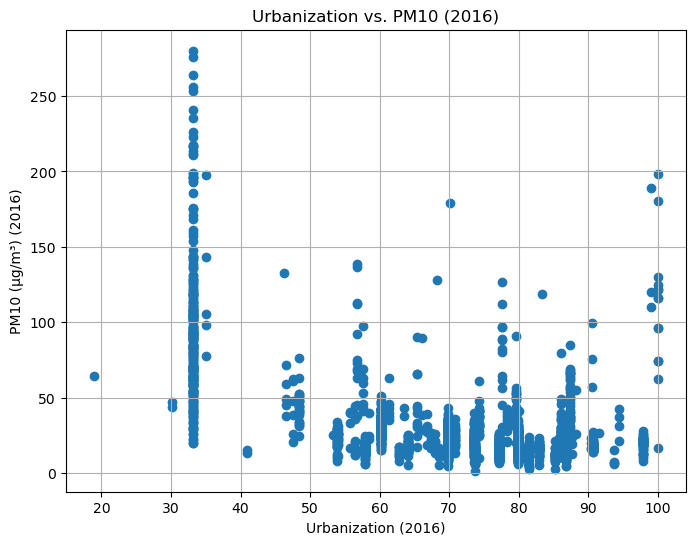

Correlation between Urbanization and PM10 (2016): -0.580

Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:           PM10 (μg/m3)   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     1289.
Date:                Sat, 22 Mar 2025   Prob (F-statistic):          1.36e-228
Time:                        21:48:39   Log-Likelihood:                -11870.
No. Observations:                2538   AIC:                         2.374e+04
Df Residuals:                    2536   BIC:                         2.376e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [16]:
# Step 5: Data Analysis
if merged_df.empty:
    print("The cleaned merged dataset is empty. Please review the cleaning rules or input data.")
else:
    # Visualization: Scatter plot of Urbanization vs. PM10.
    plt.figure(figsize=(8,6))
    plt.scatter(merged_df["Urbanization"], merged_df["PM10 (μg/m3)"])
    plt.xlabel(f"Urbanization ({selected_year})")
    plt.ylabel(f"PM10 (μg/m³) ({selected_year})")
    plt.title(f"Urbanization vs. PM10 ({selected_year})")
    plt.grid(True)
    plt.show()

    # Compute and display the Pearson correlation coefficient.
    correlation = merged_df["Urbanization"].corr(merged_df["PM10 (μg/m3)"])
    print(f"Correlation between Urbanization and PM10 ({selected_year}): {correlation:.3f}")

    # OLS Regression Analysis: Predict PM10 using Urbanization.
    X = sm.add_constant(merged_df["Urbanization"])
    y = merged_df["PM10 (μg/m3)"]
    model = sm.OLS(y, X).fit()

    # Print the regression model summary.
    print("\nRegression Model Summary:")
    print(model.summary())